In [103]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import random

/var/folders/k4/z9_wdxsd37x2_6fswxg_n1jm0000gn/T/ipykernel_5268/746665911.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(counts.index, rotation=45, ha="right")


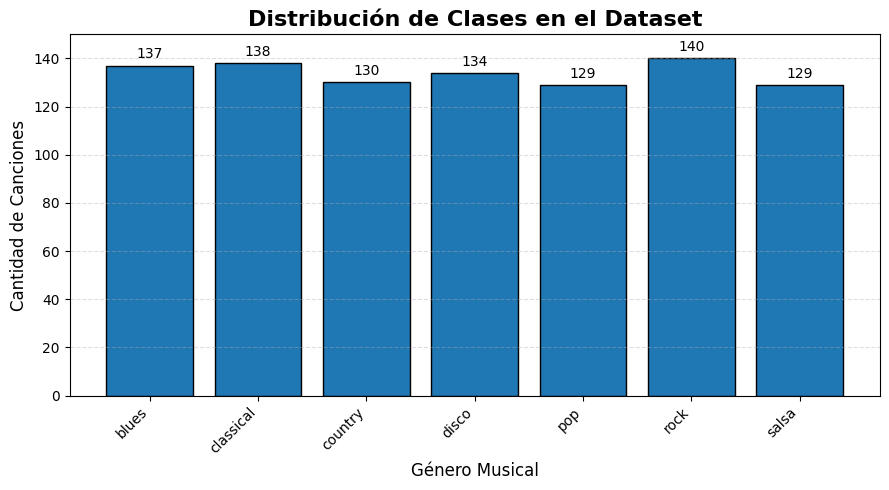

In [120]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

data = pd.read_csv("song_features.csv")
counts = data["label"].value_counts().sort_index()

counts = data["label"].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(9, 5))

bars = ax.bar(
    counts.index,
    counts.values,
    edgecolor="black"
)

ax.set_xlabel("Género Musical", fontsize=12)
ax.set_ylabel("Cantidad de Canciones", fontsize=12)
ax.set_title("Distribución de Clases en el Dataset", fontsize=16, fontweight="bold")

ax.set_xticklabels(counts.index, rotation=45, ha="right")

ax.grid(axis="y", linestyle="--", alpha=0.4)

ax.set_ylim(0, counts.values.max() + 10)

ax.bar_label(bars, padding=3, fontsize=10)

fig.tight_layout()

fig.savefig("distribucion_clases.svg", format="svg", bbox_inches="tight")
plt.show()

In [105]:
# Mapeo de etiquetas a números
label_map = {
    "rock": 0,
    "classical": 1,
    "blues": 2,
    "disco": 3,
    "country": 4,
    "pop": 5,
    "salsa": 6
}
inverse_label_map = {v: k for k, v in label_map.items()}
class_names = [inverse_label_map[i] for i in range(len(inverse_label_map))]

data["label_num"] = data["label"].map(label_map)
data = data.drop(columns="label")

In [106]:
# Corrección de la columna 'tempo' (viene como string tipo lista)
data["tempo"] = data["tempo"].apply(
    lambda x: ast.literal_eval(x)[0] if isinstance(x, str) else x
)
data["tempo"] = data["tempo"].astype(float)


# Separación features / target
X = data.drop(columns="label_num")
y = data["label_num"]

x_train, x_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=SEED,
    stratify=y
)

print("Shapes:")
print("x_train:", x_train.shape)
print("y_train:", y_train.shape)
print("x_test :", x_test.shape)
print("y_test :", y_test.shape)

Shapes:
x_train: (749, 57)
y_train: (749,)
x_test : (188, 57)
y_test : (188,)


In [107]:
## 2. Normalización

# Escalado MinMax
minmax_scaler = MinMaxScaler()
minmax_scaler.fit(x_train)

x_train_scaled = minmax_scaler.transform(x_train)
x_test_scaled = minmax_scaler.transform(x_test)

# Escalado Standard
std_scaler = StandardScaler()
std_scaler.fit(x_train)

x_train_standard = std_scaler.transform(x_train)
x_test_standard = std_scaler.transform(x_test)


In [108]:
## 3. Reducción de dimensionalidad (PCA, LDA, t-SNE, UMAP)
### PCA

pca_std = PCA(n_components=0.95)
pca_std.fit(x_train_standard)

x_train_pca2 = pca_std.transform(x_train_standard)
x_test_pca2 = pca_std.transform(x_test_standard)

print("Dimensiones tras PCA (varianza 95%):", x_train_pca2.shape[1])

Dimensiones tras PCA (varianza 95%): 34


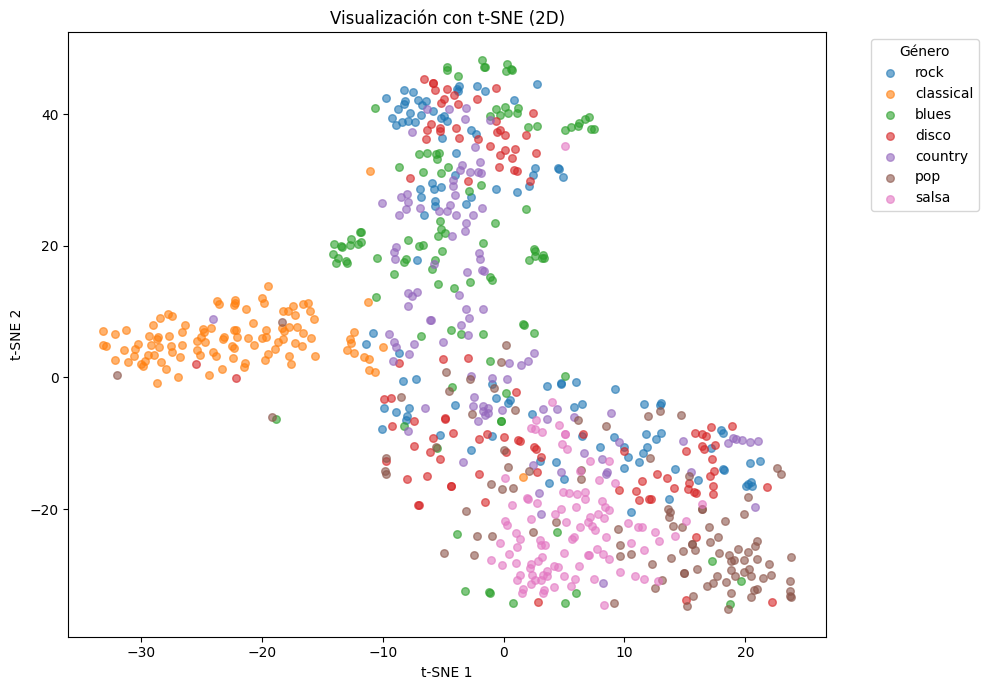

t-SNE guardado como tsne_visualization.svg


In [121]:
# t-SNE
plt.figure(figsize=(10, 7))
for label in np.unique(labels_np):
    idx = labels_np == label
    plt.scatter(
        x_train_tsne[idx, 0],
        x_train_tsne[idx, 1],
        label=inverse_label_map[label],
        alpha=0.6,
        s=30
    )

plt.title("Visualización con t-SNE (2D)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(title="Género", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()

# 👉 guardar ANTES de mostrar
plt.savefig("tsne_visualization.svg", format="svg", bbox_inches="tight")
plt.show()
print("t-SNE guardado como tsne_visualization.svg")

/Users/apple/Desktop/Universidad/4to ciclo/Machine Learning/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


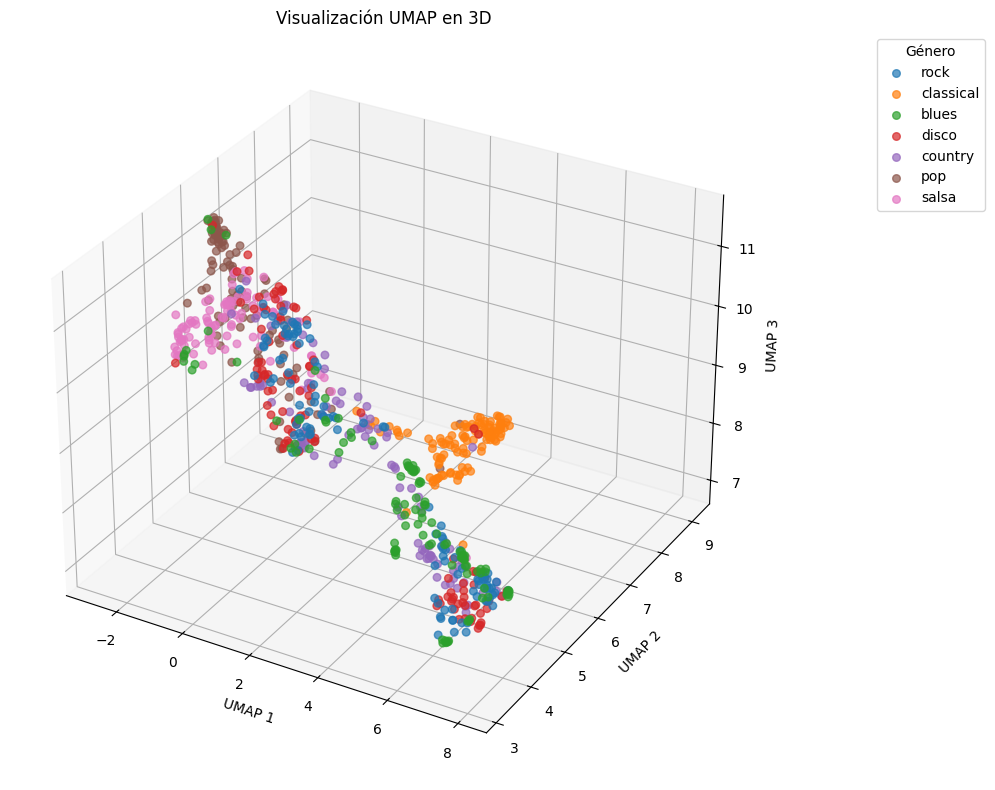

/Users/apple/Desktop/Universidad/4to ciclo/Machine Learning/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


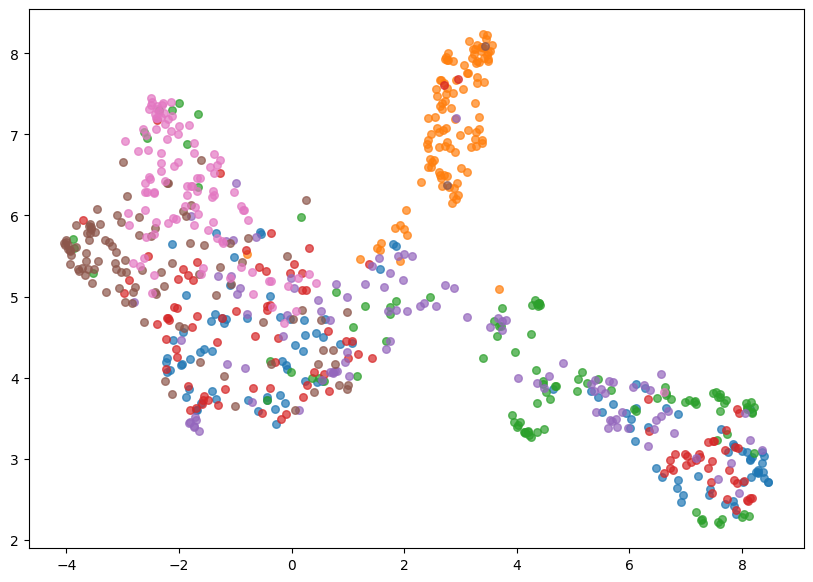

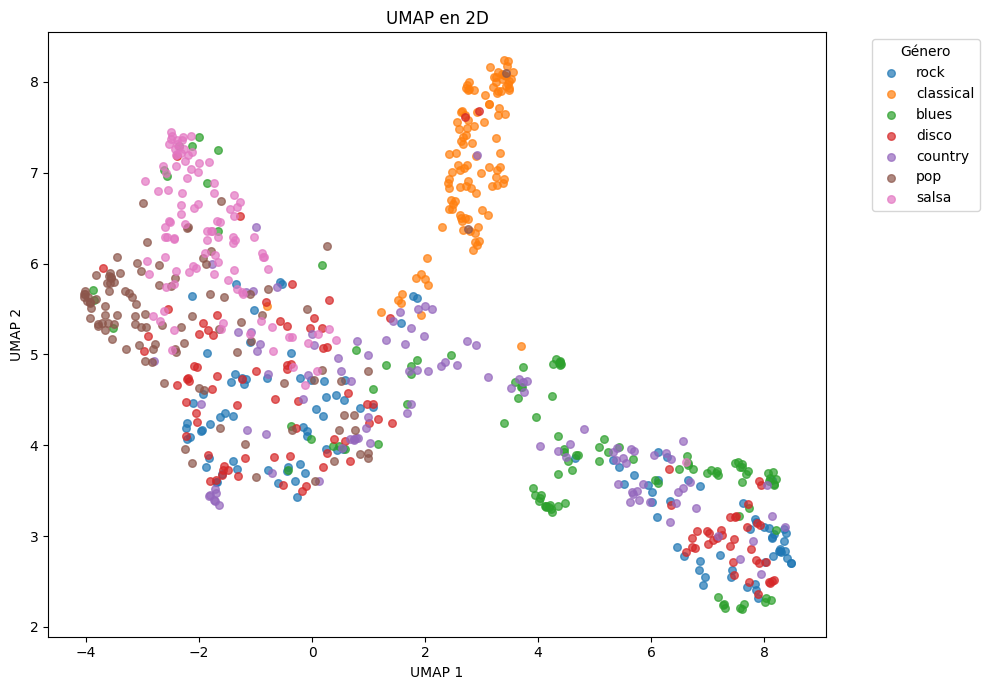

UMAP 2D guardado como umap_2d_visualization.svg


In [122]:
### UMAP

umap_3d = umap.UMAP(
    n_components=3,
    n_neighbors=20,
    min_dist=0.1,
    metric="euclidean",
    random_state=SEED
)

x_train_umap_3d = umap_3d.fit_transform(x_train_scaled)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection="3d")

for label in np.unique(labels_np):
    idx = labels_np == label
    ax.scatter(
        x_train_umap_3d[idx, 0],
        x_train_umap_3d[idx, 1],
        x_train_umap_3d[idx, 2],
        label=inverse_label_map[label],
        alpha=0.7,
        s=30
    )

ax.set_title("Visualización UMAP en 3D")
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
ax.set_zlabel("UMAP 3")
ax.legend(title="Género", bbox_to_anchor=(1.15, 1), loc="upper left")
plt.tight_layout()
plt.show()

umap_2d = umap.UMAP(
    n_components=2,
    n_neighbors=20,
    min_dist=0.1,
    metric="euclidean",
    random_state=SEED
)

x_train_umap_2d = umap_2d.fit_transform(x_train_scaled)

plt.figure(figsize=(10, 7))
for label in np.unique(labels_np):
    idx = labels_np == label
    plt.scatter(
        x_train_umap_2d[idx, 0],
        x_train_umap_2d[idx, 1],
        label=inverse_label_map[label],
        alpha=0.7,
        s=30
    )

# UMAP 2D
plt.figure(figsize=(10, 7))
for label in np.unique(labels_np):
    idx = labels_np == label
    plt.scatter(
        x_train_umap_2d[idx, 0],
        x_train_umap_2d[idx, 1],
        label=inverse_label_map[label],
        alpha=0.7,
        s=30
    )

plt.title("UMAP en 2D")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(title="Género", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()

plt.savefig("umap_2d_visualization.svg", format="svg", bbox_inches="tight")
plt.show()
print("UMAP 2D guardado como umap_2d_visualization.svg")

In [111]:
## 4. Función auxiliar: Matriz de confusión normalizada
def plot_normalized_cm(y_true, y_pred, title, save_svg=True, svg_name=None):
    cm = confusion_matrix(y_true, y_pred, normalize="true")

    # Crear figura y ejes explícitos para poder guardarla fácilmente
    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax)

    ax.set_title(title)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    plt.tight_layout()

    if save_svg:
        # Si no se especifica nombre, generarlo a partir del título
        if svg_name is None:
            base = title.lower()
            # Reemplazar caracteres no válidos en nombres de archivo
            base = "".join(c if c.isalnum() or c in "._-" else "_" for c in base)
            svg_name = base + ".svg"

        fig.savefig(svg_name, format="svg", bbox_inches="tight")
        print(f"Matriz de confusión guardada como SVG en: {svg_name}")

    plt.show()
    plt.close(fig)

/Users/apple/Desktop/Universidad/4to ciclo/Machine Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/apple/Desktop/Universidad/4to ciclo/Machine Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/apple/Desktop/Universidad/4to ciclo/Machine Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default

=== Logistic Regression – BASE ===
Mejores hiperparámetros: {'C': 1, 'penalty': 'l2', 'solver': 'saga'}
Accuracy (test): 0.7340425531914894

Classification Report:
               precision    recall  f1-score   support

        rock       0.52      0.54      0.53        28
   classical       1.00      0.93      0.96        28
       blues       0.67      0.74      0.70        27
       disco       0.63      0.63      0.63        27
     country       0.71      0.58      0.64        26
         pop       0.71      0.77      0.74        26
       salsa       0.93      0.96      0.94        26

    accuracy                           0.73       188
   macro avg       0.74      0.73      0.73       188
weighted avg       0.74      0.73      0.73       188

Matriz de confusión guardada como SVG en: logistic_regression__base____matriz_de_confusión_normalizada.svg


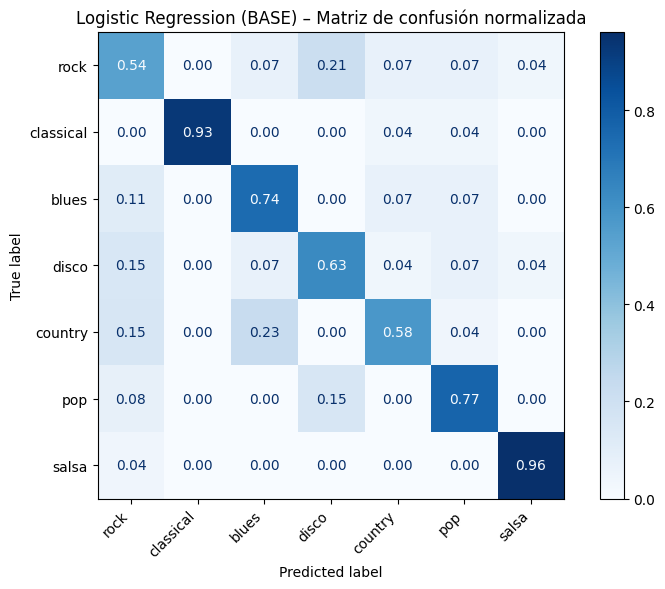

In [112]:
# 5. Modelos Clásicos

### 5.1 Modelo base: Regresión Logística (features estandarizadas)

log_model = LogisticRegression(max_iter=2000, multi_class="ovr")

params_log = {
    "C": [0.01, 0.1, 1, 10, 100, 300, 1000],
    "penalty": ["l2"],
    "solver": ["lbfgs", "saga"]
}

grid_log = GridSearchCV(
    log_model,
    params_log,
    cv=5,
    n_jobs=-1,
    scoring="accuracy"
)

grid_log.fit(x_train_standard, y_train)

best_log = grid_log.best_estimator_
y_pred_log = best_log.predict(x_test_standard)

print("=== Logistic Regression – BASE ===")
print("Mejores hiperparámetros:", grid_log.best_params_)
print("Accuracy (test):", accuracy_score(y_test, y_pred_log))
print("\nClassification Report:\n", classification_report(y_test, y_pred_log, target_names=class_names))

plot_normalized_cm(y_test, y_pred_log, "Logistic Regression (BASE) – Matriz de confusión normalizada")


In [113]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# LDA: se entrena sobre los datos estandarizados actuales
lda = LinearDiscriminantAnalysis(n_components=len(np.unique(y_train)) - 1)

lda.fit(x_train_standard, y_train)

x_train_lda2 = lda.transform(x_train_standard)
x_test_lda2 = lda.transform(x_test_standard)

print("Shapes LDA:")
print("x_train_lda2:", x_train_lda2.shape)
print("y_train     :", y_train.shape)
print("x_test_lda2 :", x_test_lda2.shape)
print("y_test      :", y_test.shape)

Shapes LDA:
x_train_lda2: (749, 6)
y_train     : (749,)
x_test_lda2 : (188, 6)
y_test      : (188,)


/Users/apple/Desktop/Universidad/4to ciclo/Machine Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/apple/Desktop/Universidad/4to ciclo/Machine Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/apple/Desktop/Universidad/4to ciclo/Machine Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default

=== Logistic Regression + LDA ===
Mejores hiperparámetros: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy (test): 0.7446808510638298

Classification Report:
               precision    recall  f1-score   support

        rock       0.58      0.64      0.61        28
   classical       0.96      0.96      0.96        28
       blues       0.68      0.70      0.69        27
       disco       0.67      0.59      0.63        27
     country       0.75      0.58      0.65        26
         pop       0.74      0.77      0.75        26
       salsa       0.83      0.96      0.89        26

    accuracy                           0.74       188
   macro avg       0.74      0.74      0.74       188
weighted avg       0.74      0.74      0.74       188

Matriz de confusión guardada como SVG en: logistic_regression___lda___matriz_de_confusión_normalizada.svg


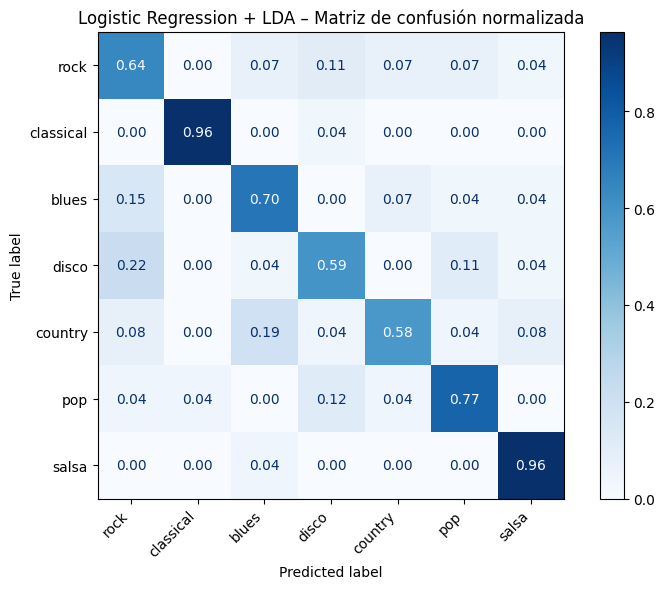

In [114]:
### 5.2 Regresión Logística sobre features LDA (StandardScaler + LDA)
log_lda = LogisticRegression(max_iter=2000, multi_class="ovr")

params_log_lda = {
    "C": [0.01, 0.1, 1, 10, 100, 300, 1000],
    "penalty": ["l2"],
    "solver": ["lbfgs", "saga"]
}

grid_log_lda = GridSearchCV(
    log_lda,
    params_log_lda,
    cv=5,
    n_jobs=-1,
    scoring="accuracy"
)

grid_log_lda.fit(x_train_lda2, y_train)

best_log_lda = grid_log_lda.best_estimator_
y_pred_log_lda = best_log_lda.predict(x_test_lda2)

print("=== Logistic Regression + LDA ===")
print("Mejores hiperparámetros:", grid_log_lda.best_params_)
print("Accuracy (test):", accuracy_score(y_test, y_pred_log_lda))
print("\nClassification Report:\n", classification_report(y_test, y_pred_log_lda, target_names=class_names))

plot_normalized_cm(y_test, y_pred_log_lda, "Logistic Regression + LDA – Matriz de confusión normalizada")


=== SVM RBF – Escalado MinMax ===
Mejores hiperparámetros: {'C': 10, 'gamma': 'scale'}
Accuracy (test): 0.7659574468085106

Classification Report:
               precision    recall  f1-score   support

        rock       0.66      0.68      0.67        28
   classical       1.00      0.96      0.98        28
       blues       0.66      0.78      0.71        27
       disco       0.62      0.59      0.60        27
     country       0.82      0.69      0.75        26
         pop       0.79      0.73      0.76        26
       salsa       0.86      0.92      0.89        26

    accuracy                           0.77       188
   macro avg       0.77      0.77      0.77       188
weighted avg       0.77      0.77      0.77       188

Matriz de confusión guardada como SVG en: svm_rbf__minmax____matriz_de_confusión_normalizada.svg


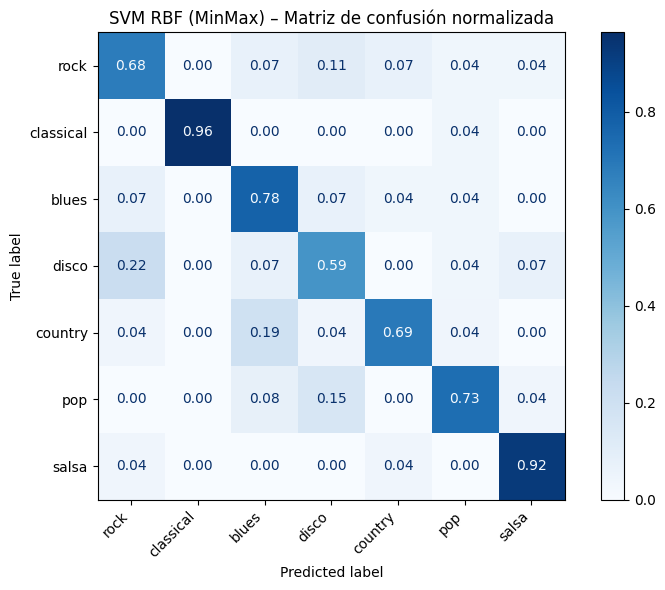

In [115]:
### 5.3 Modelo adicional 1: SVM con kernel RBF (features MinMax)

params_svm = {
    "C": [1, 10, 100],
    "gamma": ["scale", 0.001, 0.01, 0.1]
}

svm_model = GridSearchCV(
    estimator=SVC(kernel="rbf"),
    param_grid=params_svm,
    cv=5,
    n_jobs=-1,
    scoring="accuracy"
)

svm_model.fit(x_train_scaled, y_train)
best_svm = svm_model.best_estimator_
y_pred_svm = best_svm.predict(x_test_scaled)

print("=== SVM RBF – Escalado MinMax ===")
print("Mejores hiperparámetros:", svm_model.best_params_)
print("Accuracy (test):", accuracy_score(y_test, y_pred_svm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm, target_names=class_names))

plot_normalized_cm(y_test, y_pred_svm, "SVM RBF (MinMax) – Matriz de confusión normalizada")


=== SVM RBF + PCA ===
Mejores hiperparámetros: {'C': 10, 'gamma': 0.01}
Accuracy (test): 0.776595744680851

Classification Report:
               precision    recall  f1-score   support

        rock       0.79      0.68      0.73        28
   classical       0.96      0.96      0.96        28
       blues       0.68      0.78      0.72        27
       disco       0.61      0.63      0.62        27
     country       0.79      0.73      0.76        26
         pop       0.78      0.69      0.73        26
       salsa       0.83      0.96      0.89        26

    accuracy                           0.78       188
   macro avg       0.78      0.78      0.77       188
weighted avg       0.78      0.78      0.78       188

Matriz de confusión guardada como SVG en: svm_rbf___pca___matriz_de_confusión_normalizada.svg


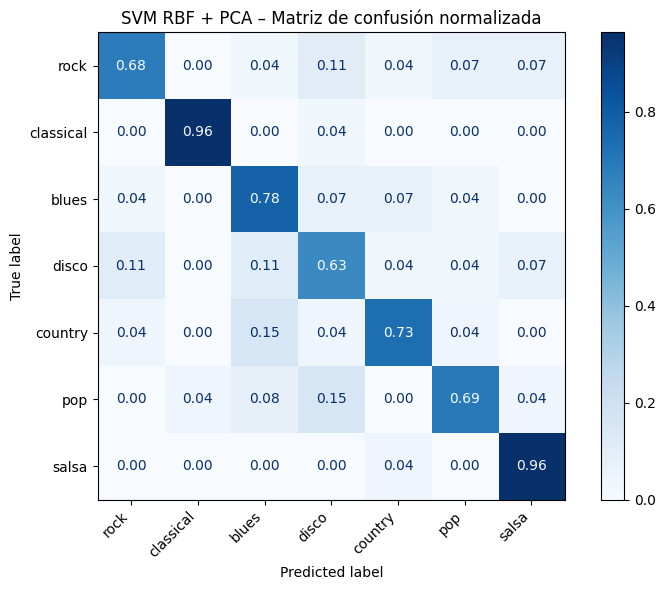

In [116]:
### 5.3.1 SVM sobre PCA (opcional, análisis comparativo)
svm_pca = GridSearchCV(
    estimator=SVC(kernel="rbf"),
    param_grid=params_svm,
    cv=5,
    n_jobs=-1,
    scoring="accuracy"
)

svm_pca.fit(x_train_pca2, y_train)
best_svm_pca = svm_pca.best_estimator_
y_pred_svm_pca = best_svm_pca.predict(x_test_pca2)

print("=== SVM RBF + PCA ===")
print("Mejores hiperparámetros:", svm_pca.best_params_)
print("Accuracy (test):", accuracy_score(y_test, y_pred_svm_pca))
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm_pca, target_names=class_names))

plot_normalized_cm(y_test, y_pred_svm_pca, "SVM RBF + PCA – Matriz de confusión normalizada")

=== SVM RBF + LDA ===
Mejores hiperparámetros: {'C': 1, 'gamma': 0.1}
Accuracy (test): 0.7393617021276596

Classification Report:
               precision    recall  f1-score   support

        rock       0.62      0.64      0.63        28
   classical       0.96      0.96      0.96        28
       blues       0.61      0.70      0.66        27
       disco       0.67      0.67      0.67        27
     country       0.65      0.50      0.57        26
         pop       0.76      0.73      0.75        26
       salsa       0.89      0.96      0.93        26

    accuracy                           0.74       188
   macro avg       0.74      0.74      0.74       188
weighted avg       0.74      0.74      0.74       188

Matriz de confusión guardada como SVG en: svm_rbf___lda___matriz_de_confusión_normalizada.svg


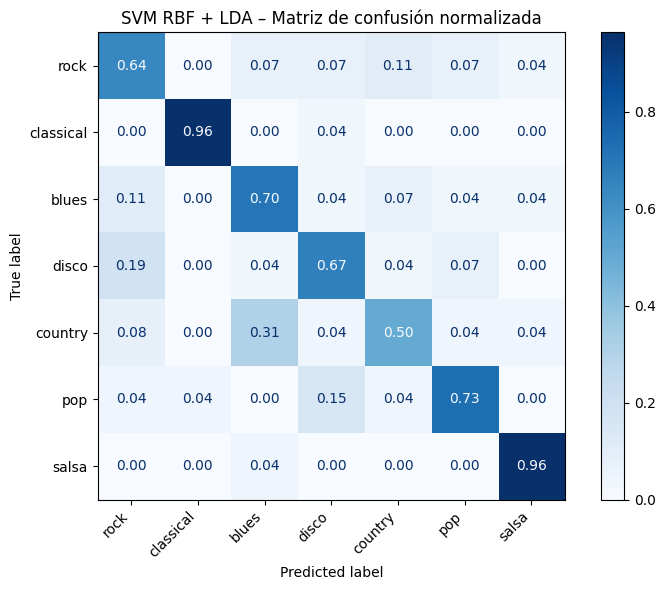

In [117]:
### 5.3.2 SVM sobre LDA (opcional, análisis comparativo)
svm_lda = GridSearchCV(
    estimator=SVC(kernel="rbf"),
    param_grid=params_svm,
    cv=5,
    n_jobs=-1,
    scoring="accuracy"
)

svm_lda.fit(x_train_lda2, y_train)
best_svm_lda = svm_lda.best_estimator_
y_pred_svm_lda = best_svm_lda.predict(x_test_lda2)

print("=== SVM RBF + LDA ===")
print("Mejores hiperparámetros:", svm_lda.best_params_)
print("Accuracy (test):", accuracy_score(y_test, y_pred_svm_lda))
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm_lda, target_names=class_names))

plot_normalized_cm(y_test, y_pred_svm_lda, "SVM RBF + LDA – Matriz de confusión normalizada")

Epoch 000 | Loss: 1.8755 | Test Acc: 0.1702
Epoch 001 | Loss: 1.6098 | Test Acc: 0.2181
Epoch 002 | Loss: 1.4509 | Test Acc: 0.4574
Epoch 003 | Loss: 1.3283 | Test Acc: 0.6596
Epoch 004 | Loss: 1.2323 | Test Acc: 0.6649
Epoch 005 | Loss: 1.1382 | Test Acc: 0.6968
Epoch 006 | Loss: 1.0562 | Test Acc: 0.6915
Epoch 007 | Loss: 1.0118 | Test Acc: 0.7074
Epoch 008 | Loss: 0.9384 | Test Acc: 0.7234
Epoch 009 | Loss: 0.8715 | Test Acc: 0.7447
Epoch 010 | Loss: 0.8252 | Test Acc: 0.7340
Epoch 011 | Loss: 0.7874 | Test Acc: 0.7553
Epoch 012 | Loss: 0.7342 | Test Acc: 0.7394
Epoch 013 | Loss: 0.7028 | Test Acc: 0.7447
Epoch 014 | Loss: 0.6728 | Test Acc: 0.7606
Epoch 015 | Loss: 0.6307 | Test Acc: 0.7660
Epoch 016 | Loss: 0.6123 | Test Acc: 0.7606
Epoch 017 | Loss: 0.6021 | Test Acc: 0.7660
Epoch 018 | Loss: 0.5860 | Test Acc: 0.7872
Epoch 019 | Loss: 0.5112 | Test Acc: 0.7713
Epoch 020 | Loss: 0.5084 | Test Acc: 0.7660
Epoch 021 | Loss: 0.4603 | Test Acc: 0.7766
Epoch 022 | Loss: 0.4274 | Test 

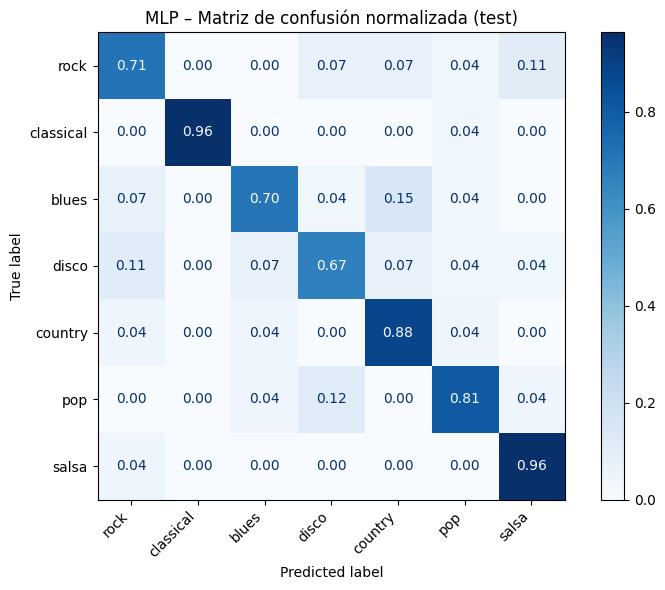

In [118]:
# 6. Modelo Moderno: MLP en PyTorch
X_train_tensor = torch.tensor(x_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(x_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


#    NUEVA ARQUITECTURA PROFUNDA

class OptimizedMLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.35),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.30),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.25),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.15),

            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.net(x)


input_dim = X_train_tensor.shape[1]
num_classes = len(np.unique(y_train))

model = OptimizedMLP(input_dim, num_classes)

#        PÉRDIDA CON PESOS POR CLASE (FOCO EN ROCK/BLUES/DISCO/POP)

class_counts = np.bincount(y_train.values, minlength=num_classes)

base_weights = class_counts.sum() / (class_counts + 1e-6)
base_weights = base_weights / base_weights.mean()

refuerzo_idx = [
    label_map["rock"],
    label_map["blues"],
    label_map["disco"],
    label_map["pop"]
]
for idx in refuerzo_idx:
    base_weights[idx] *= 1.5

for idx in [label_map["classical"], label_map["salsa"]]:
    base_weights[idx] *= 0.9

class_weights_tensor = torch.tensor(base_weights, dtype=torch.float32)

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.01)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", patience=8, factor=0.5
)

TARGET_ACC = 0.81


# =============================================================
#      ENTRENAMIENTO OPTIMIZADO + GRADIENT CLIPPING
# =============================================================

def train_one_epoch(model, loader):
    model.train()
    total_loss = 0.0
    for X_batch, y_batch in loader:
        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=3.0)
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


def evaluate_accuracy(model, loader):
    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            outputs = model(X_batch)
            predictions = outputs.argmax(dim=1)
            y_pred.extend(predictions.numpy())
            y_true.extend(y_batch.numpy())
    return accuracy_score(y_true, y_pred)


best_acc = 0.0
best_epoch = 0
best_state_dict = None

epochs = 300
patience = 70
wait = 0

for epoch in range(epochs):
    loss = train_one_epoch(model, train_loader)
    acc = evaluate_accuracy(model, test_loader)

    scheduler.step(acc)

    print(f"Epoch {epoch:03d} | Loss: {loss:.4f} | Test Acc: {acc:.4f}")

    if acc > best_acc:
        best_acc = acc
        best_epoch = epoch
        best_state_dict = model.state_dict()
        wait = 0
    else:
        wait += 1

    if best_acc >= TARGET_ACC:
        print(f"\nSe alcanzó el accuracy objetivo ({best_acc:.4f} ≥ {TARGET_ACC}) en el epoch {best_epoch}.")
        break

    if wait >= patience:
        print("\nEarly stopping activado por falta de mejora.")
        break

print(f"\nMejor accuracy en test durante el entrenamiento: {best_acc:.4f} (epoch {best_epoch})")

if best_state_dict is not None:
    model.load_state_dict(best_state_dict)

# Evaluación final
model.eval()
y_true_mlp = []
y_pred_mlp = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        preds = outputs.argmax(dim=1)
        y_true_mlp.extend(y_batch.numpy())
        y_pred_mlp.extend(preds.numpy())

print("=== MLP PyTorch (MÉTODO MODERNO, CON PESOS POR CLASE + UMBRAL ACCURACY) ===")
print("\nClassification Report:\n", classification_report(y_true_mlp, y_pred_mlp, target_names=class_names))

plot_normalized_cm(y_true_mlp, y_pred_mlp, "MLP – Matriz de confusión normalizada (test)")